In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

import polars as pl
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.preprocessing import SplineTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import xgboost as xgb
import lightgbm as lgb
from lightgbm import early_stopping

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

C:\Users\valan\Desktop\Projects\nyc-citi-bike-daily-demand-forecast\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Feature engineering

In [2]:
df = (
    pl.read_parquet("../data/processed/*.parquet")
    .group_by("ride_date")
    .agg(
        pl.col("unique_rides").sum().alias("total_rides")
    )
    .filter(pl.col("ride_date") >= datetime(2023, 1, 1))
    .sort("ride_date")
    .to_pandas()
    #.set_index("ride_date")
)
df.head()

,ride_date,total_rides
0,2023-01-01,50642
1,2023-01-02,58241
2,2023-01-03,51789
3,2023-01-04,74454
4,2023-01-05,71440


In [3]:
# List of lags
lags = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 30, 54, 60]

# Create lag features
for lag in lags:
    df[f'lag-{lag}d'] = df['total_rides'].shift(lag)

# Date-based features
df['day_of_week'] = df['ride_date'].dt.dayofweek
df['month_day'] = df['ride_date'].dt.day
df['month'] = df['ride_date'].dt.month
df['week_of_year'] = df['ride_date'].dt.isocalendar().week
df['day_of_year'] = df['ride_date'].dt.dayofyear

# Moving average features
ma_windows = [3, 7, 14, 30]

# Create rolling mean features including the current value
for window in ma_windows:
    df[f'ma_{window}d'] = df['total_rides'].rolling(window=window).mean()

# Make splines on the time-based features
dow_spline = SplineTransformer(n_knots=10, degree=3, include_bias=False)
dow_spline.fit(df[['month_day']])  # Fit only on train
X_md_spline = dow_spline.transform(df[['month_day']])
spline_cols = [f'month_day_spline_{i}' for i in range(X_md_spline.shape[1])]
df[spline_cols] = X_md_spline

# Holidays
nyc_holidays = [
    '2023-01-01',  # New Year's Day
    '2023-01-02',  # New Year's Day (Observed)
    '2023-01-16',  # Martin Luther King Jr. Day
    '2023-02-12',  # Lincoln's Birthday
    '2023-02-20',  # Presidents' Day (Washington’s Birthday)
    '2023-05-29',  # Memorial Day
    '2023-06-19',  # Juneteenth
    '2023-07-04',  # Independence Day
    '2023-09-04',  # Labor Day
    '2023-10-09',  # Columbus Day
    '2023-11-07',  # Election Day
    '2023-11-10',  # Veterans Day (Observed)
    '2023-11-11',  # Veterans Day
    '2023-11-23',  # Thanksgiving
    '2023-12-25',  # Christmas Day

    '2024-01-01',  # New Year's Day
    '2024-01-15',  # Martin Luther King Jr. Day
    '2024-02-12',  # Lincoln's Birthday
    '2024-02-19',  # Presidents' Day
    '2024-05-27',  # Memorial Day
    '2024-06-19',  # Juneteenth
    '2024-07-04',  # Independence Day
    '2024-09-02',  # Labor Day
    '2024-10-14',  # Columbus Day
    '2024-11-05',  # Election Day
    '2024-11-11',  # Veterans Day
    '2024-11-28',  # Thanksgiving
    '2024-12-25',  # Christmas Day

    '2025-01-01',  # New Year's Day
    '2025-01-20',  # Martin Luther King Jr. Day
    '2025-02-12',  # Lincoln's Birthday
    '2025-02-17',  # Presidents' Day
    '2025-05-26',  # Memorial Day
    '2025-06-19',  # Juneteenth
    '2025-07-04',  # Independence Day
    '2025-09-01',  # Labor Day
    '2025-10-13',  # Columbus Day
    '2025-11-04',  # Election Day
    '2025-11-11',  # Veterans Day
    '2025-11-27',  # Thanksgiving
    '2025-12-25'   # Christmas Day
]


# Convert holiday_dates to datetime
holiday_dates = pd.to_datetime(nyc_holidays)
df['is_holiday'] = df['ride_date'].isin(nyc_holidays).astype(int)

# Target variable
df['t+7d'] = df['total_rides'].shift(-7)

# Drop rows with NaNs
df = (
    df
    #.drop("total_rides", axis=1)
    .dropna()
)
df.head()

,ride_date,total_rides,lag-1d,lag-2d,lag-3d,lag-4d,lag-5d,lag-6d,lag-7d,lag-14d,lag-21d,lag-28d,lag-30d,lag-54d,lag-60d,day_of_week,month_day,month,week_of_year,day_of_year,ma_3d,ma_7d,ma_14d,ma_30d,month_day_spline_0,month_day_spline_1,month_day_spline_2,month_day_spline_3,month_day_spline_4,month_day_spline_5,month_day_spline_6,month_day_spline_7,month_day_spline_8,month_day_spline_9,month_day_spline_10,is_holiday,t+7d
60,2023-03-02,73762,70245.0,40679.0,58387.0,54677.0,43325.0,59603.0,65595.0,74622.0,76063.0,63159.0,57398.0,59158.0,50642.0,3,2,3,9,61,61562.000000,57239.714286,57202.071429,61336.933333,0.057167,0.590167,0.348167,0.004500,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,77315.0
61,2023-03-03,65344,73762.0,70245.0,40679.0,58387.0,54677.0,43325.0,59603.0,49586.0,83968.0,38062.0,60429.0,49454.0,58241.0,4,3,3,9,62,69783.666667,58059.857143,58327.642857,61500.766667,0.010667,0.414667,0.538667,0.036000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,59459.0
62,2023-03-04,56830,65344.0,73762.0,70245.0,40679.0,58387.0,54677.0,43325.0,52125.0,63800.0,24810.0,63159.0,61588.0,51789.0,5,4,3,9,63,65312.000000,59989.142857,58663.714286,61289.800000,0.000167,0.221167,0.657167,0.121500,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,49164.0
63,2023-03-05,64785,56830.0,65344.0,73762.0,70245.0,40679.0,58387.0,54677.0,51309.0,55662.0,49842.0,38062.0,66674.0,74454.0,6,5,3,9,64,62319.666667,61433.142857,59626.285714,62180.566667,0.000000,0.085333,0.630667,0.282667,0.001333,0.0,0.0,0.0,0.0,0.0,0.0,0,56572.0
64,2023-03-06,72655,64785.0,56830.0,65344.0,73762.0,70245.0,40679.0,58387.0,70881.0,72025.0,64834.0,24810.0,67100.0,71440.0,0,6,3,10,65,64756.666667,63471.428571,59753.000000,63775.400000,0.000000,0.020833,0.479167,0.479167,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0,32823.0


# Time-based split

We use the standard way to split the data:

`|<------ Train ------>|<-- Validation -->|<-- Test -->|`

In [4]:
# Define date boundaries
train_end_date = pd.Timestamp("2024-04-30")
val_start_date = pd.Timestamp("2024-05-01")
val_end_date = pd.Timestamp("2024-05-31")
test_start_date = pd.Timestamp("2024-06-01")
test_end_date = pd.Timestamp("2024-06-20")

# Time-based split
train_df = df[df['ride_date'] <= train_end_date].copy()
val_df   = df[(df['ride_date'] >= val_start_date) & (df['ride_date'] <= val_end_date)].copy()
test_df  = df[(df['ride_date'] >= test_start_date) & (df['ride_date'] <= test_end_date)].copy()

# Modeling

We use XGBoost and LightGBM.

In [5]:
# Get the features and target variable
X_train = train_df.drop(["ride_date", "t+7d"], axis=1).to_numpy()
X_val = val_df.drop(["ride_date", "t+7d"], axis=1).to_numpy()
X_test = test_df.drop(["ride_date", "t+7d"], axis=1).to_numpy()

y_train = train_df["t+7d"].to_numpy()
y_val = val_df["t+7d"].to_numpy()
y_test = test_df["t+7d"].to_numpy()

## Helper function for evaluation

In [6]:
def evaluate_model(
    model, 
    X_train, y_train, 
    X_val, y_val, 
    X_test, y_test, 
    model_name="Model"
):
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_val   = model.predict(X_val)
    y_pred_test  = model.predict(X_test)

    # Train metrics
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100

    # Validation metrics
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    mae_val = mean_absolute_error(y_val, y_pred_val)
    mape_val = mean_absolute_percentage_error(y_val, y_pred_val) * 100

    # Test metrics
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100

    # Print results
    print(f"\nTrain Set Metrics ({model_name}):")
    print(f"RMSE: {rmse_train:.2f}")
    print(f"MAE: {mae_train:.2f}")
    print(f"MAPE: {mape_train:.2f}%")

    print(f"\nValidation Set Metrics ({model_name}):")
    print(f"RMSE: {rmse_val:.2f}")
    print(f"MAE: {mae_val:.2f}")
    print(f"MAPE: {mape_val:.2f}%")

    print(f"\nTest Set Metrics ({model_name}):")
    print(f"RMSE: {rmse_test:.2f}")
    print(f"MAE: {mae_test:.2f}")
    print(f"MAPE: {mape_test:.2f}%")

    # Return all metrics in a structured format
    return {
        "train": {"rmse": rmse_train, "mae": mae_train, "mape": mape_train},
        "val":   {"rmse": rmse_val,   "mae": mae_val,   "mape": mape_val},
        "test":  {"rmse": rmse_test,  "mae": mae_test,  "mape": mape_test}
    }

## XGBoost

In [7]:
from xgboost.callback import EarlyStopping

def objective(trial):
    params = {
        "n_estimators": 200,  # Fixed
        "eval_metric": "rmse",
        "objective": "reg:squarederror",
        "max_depth": trial.suggest_int("max_depth", 5, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.5, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True),   # L1
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True), # L2
        "random_state": 42
    }
    early_stop = xgb.callback.EarlyStopping(
        rounds=100, metric_name='rmse', data_name='validation_0', save_best=True
    )
    model = xgb.XGBRegressor(**params, callbacks=[early_stop])
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse  # Minimize RMSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=-1)

# Best params
print("Best hyperparameters:", study.best_params)

# Train final model with best params and fixed n_estimators
early_stop = xgb.callback.EarlyStopping(
        rounds=100, metric_name='rmse', data_name='validation_0', save_best=True
    )
best_xgb_model = xgb.XGBRegressor(
    **study.best_params,
    n_estimators=200,
    objective="reg:squarederror",
    eval_metric="rmse",
    callbacks=[early_stop],
    random_state=42,
    n_jobs=-1
)
best_xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
metrics = evaluate_model(best_xgb_model, X_train, y_train, X_val, y_val, X_test, y_test, model_name="XGBoost")

Best hyperparameters: {'max_depth': 8, 'learning_rate': 0.24970471305559827, 'subsample': 0.6035010392318644, 'colsample_bytree': 0.8270769482880588, 'reg_alpha': 1.0751641923104576, 'reg_lambda': 2.3780053947832757e-06}

Train Set Metrics (XGBoost):
RMSE: 5601.75
MAE: 4282.32
MAPE: 5.49%

Validation Set Metrics (XGBoost):
RMSE: 28832.26
MAE: 24326.78
MAPE: 17.74%

Test Set Metrics (XGBoost):
RMSE: 41327.94
MAE: 36919.10
MAPE: 22.62%


## LightGBM

In [8]:
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "n_estimators": 200,  # Fixed
        "num_leaves": trial.suggest_int("num_leaves", 3, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 5),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": -1,
        "force_col_wise": True
}
    
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        callbacks=[early_stopping(100, verbose=False)]
    )
    
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=-1)

# Best params
print("Best hyperparameters:", study.best_params)

# Train final model with best params
best_params = study.best_params
best_lgbm_model = lgb.LGBMRegressor(
    **best_params,
    n_estimators=200,
    random_state=42,
    verbosity=-1  # Suppress model messages
)
best_lgbm_model.fit(X_train, y_train)  # No verbose parameter needed here

# Evaluate
metrics = evaluate_model(best_lgbm_model, X_train, y_train, X_val, y_val, X_test, y_test, model_name="LightGBM")

Best hyperparameters: {'num_leaves': 6, 'learning_rate': 0.225697744405712, 'feature_fraction': 0.942696910304837, 'bagging_fraction': 0.4461726104127851, 'bagging_freq': 6, 'min_child_samples': 39, 'lambda_l1': 8.444795307195129, 'lambda_l2': 2.787041502684228, 'min_split_gain': 0.1933438535108588, 'subsample': 0.9451020481567094, 'subsample_freq': 3, 'colsample_bytree': 0.8022150613657137, 'reg_alpha': 0.6789166104723859, 'reg_lambda': 0.21323723737771272}

Train Set Metrics (LightGBM):
RMSE: 13379.84
MAE: 9704.12
MAPE: 13.99%

Validation Set Metrics (LightGBM):
RMSE: 30929.05
MAE: 27421.73
MAPE: 21.23%

Test Set Metrics (LightGBM):
RMSE: 31027.17
MAE: 28753.65
MAPE: 17.64%


The LightGBM model seems to generalize well to future data but the metrics need improvement. 

In [9]:
import joblib

# Assume `model` is your trained model
joblib.dump(best_lgbm_model, "../models/daily_ridership_model_lightgbm.joblib")

['../models/daily_ridership_model_lightgbm.joblib']

# Comparison with real data

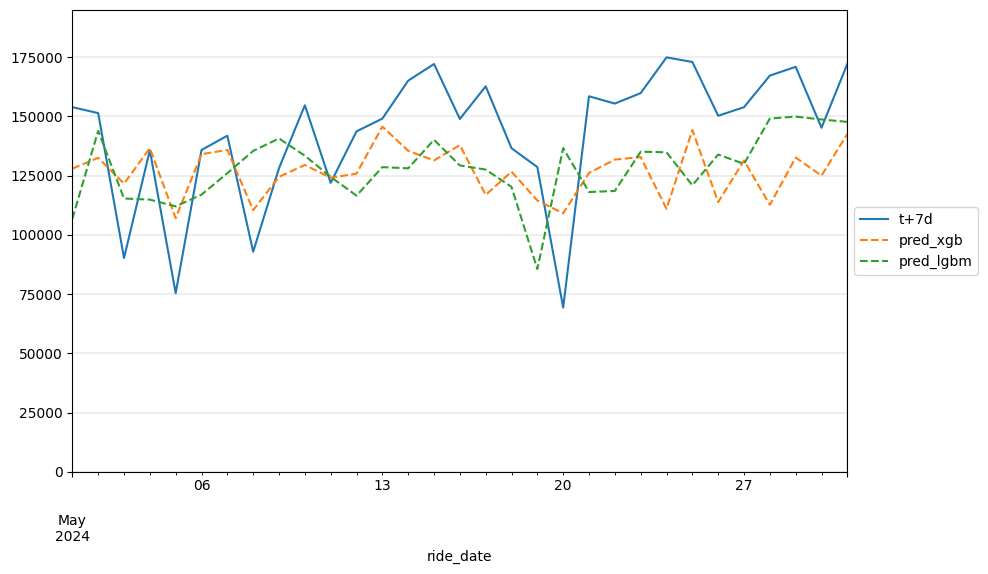

In [10]:
y_pred_test_xgb = best_xgb_model.predict(X_val)
y_pred_test_lgbm = best_lgbm_model.predict(X_val)

comparison_df = (
    val_df[["ride_date", "t+7d"]]
    .assign(
        pred_xgb = y_pred_test_xgb,
        pred_lgbm = y_pred_test_lgbm
    )
    .set_index("ride_date")
)

fig, ax = plt.subplots(figsize=(10,6), dpi=100)

comparison_df.plot(y="t+7d", ax=ax)
comparison_df.plot(y="pred_xgb", linestyle='--', ax=ax)
comparison_df.plot(y="pred_lgbm", linestyle='--', ax=ax)

top_value = np.max(np.maximum.reduce([
    comparison_df["pred_lgbm"].values,
    comparison_df["pred_xgb"].values,
    comparison_df["t+7d"].values
])) + 20_000

plt.ylim(0, top_value)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(lw=0.3)
plt.show()

# Feature importance

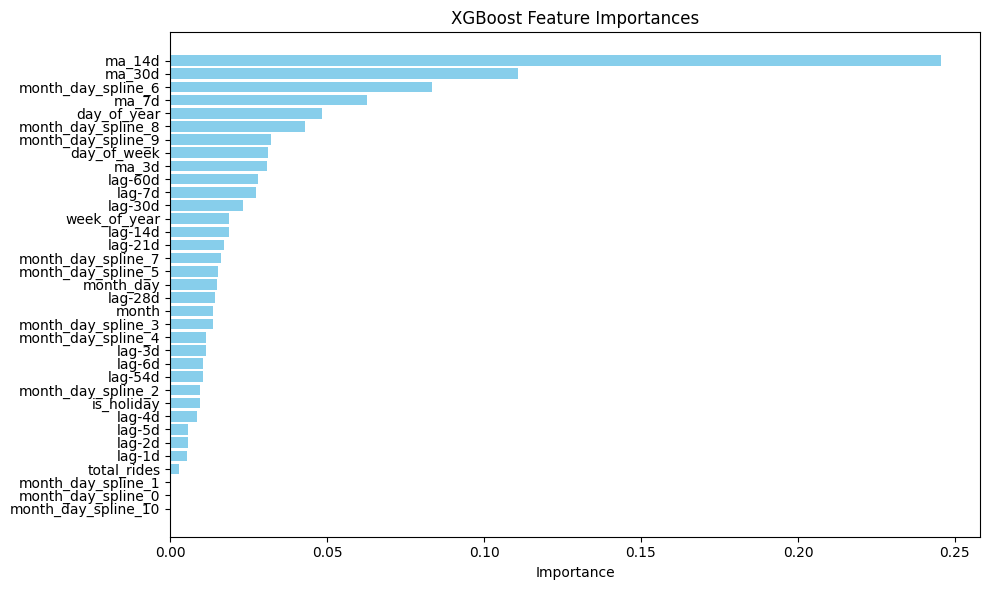

In [11]:
feature_names = train_df.drop(["ride_date", "t+7d"], axis=1).columns.tolist()
importance = best_xgb_model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

# Plot using matplotlib
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()